In [1]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts

from mne_connectivity import spectral_connectivity_epochs
from mne.datasets import sample
import seaborn as sns

from scipy.signal import welch
import yasa
import constants
import numpy as np

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))


In [ ]:
data_type = ['Wake','N1', 'N2', 'N3', 'REM'][int(sys.argv[1])]
TS_Fresh_setting = ['Minimal' , 'Efficient'][int(sys.argv[2])]
connectivity_setting = ['delta' , 'theta' , 'alpha', 'sigma', 'beta', 'gamma'][int(sys.argv[3])]

data_type - TS_Fresh_setting (Minimal) X cconnectivity_setting

In [2]:
settings = []
for data_type in ['Wake','N1', 'N2', 'N3', 'REM']:
    for TS_Fresh_setting in ['Minimal']:
        for connectivity_setting in  ['delta' , 'theta' , 'alpha', 'sigma', 'beta', 'gamma']:
            settings.append( (data_type , TS_Fresh_setting, connectivity_setting) )

In [8]:
len(settings)

30

In [4]:
data_type , TS_Fresh_setting, connectivity_setting = settings[0]

In [7]:
connectivity_setting

'delta'

In [17]:
data_type = 'N1'
folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/'
paths = joblib.load(folder + data_type + '_paths.pkl')

In [18]:
%%capture captured_output
connectivity_df_list = []

t1 = time.time()
for path in paths['selected_paths']:
    method = 'pli'
    
    channels = constants.channel_list
    channel_names = constants.channel_list
    
    data_epo = mne.read_epochs(path)
    df_full = data_epo.to_data_frame()
    
    
    #generate coherence data across electrodes
    con_pli =  spectral_connectivity_epochs(data_epo , method=method , sfreq=256,fmin=16, fmax=30, faverage=False)
    
    connectivity_data = con_pli.get_data('dense')
    channel_data = connectivity_data
    
    # Create an empty DataFrame for the means
    df = pd.DataFrame(index=channel_names, columns=channel_names)
    
    # Fill the DataFrame with connectivity values
    for i in range(len(channel_names)):
        for j in range(len(channel_names)):
            channel_1 = channel_names[i]
            channel_2 = channel_names[j]
            connectivity_value = channel_data[i, j]
            df.loc[channel_1, channel_2] = connectivity_value.mean()
            df.loc[channel_2, channel_1] = connectivity_value.mean()
            
    df_mean = df.apply(pd.to_numeric)
    
    
    
    # Create an empty DataFrame for the stds
    df = pd.DataFrame(index=channel_names, columns=channel_names)
    
    # Fill the DataFrame with connectivity values
    for i in range(len(channel_names)):
        for j in range(len(channel_names)):
            channel_1 = channel_names[i]
            channel_2 = channel_names[j]
            connectivity_value = channel_data[i, j]
            df.loc[channel_1, channel_2] = connectivity_value.std()
            df.loc[channel_2, channel_1] = connectivity_value.std()
            
    df_std = df.apply(pd.to_numeric)
    
    new_df_row = {}
    
    for df , df_type in zip([df_mean , df_std] , ['mean' , 'std' ] ): 
        
        #4. Go through all of the power_bands and add data as a column for a new dataframe with power_band + channel_1 + channel_2 as feature(s)
        for i, channel in enumerate(channels):
            for channel_2 in channels[i+1:]:
                val = df.loc[channel, channel_2]
                new_df_row[df_type + '_' + channel + '_' + channel_2] = [val]
                
    new_df = pd.DataFrame.from_dict(new_df_row, orient = 'columns')
    
    connectivity_df_list.append(new_df)

save_folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/Connectivity/test/'
connectivity_df = pd.concat(connectivity_df_list)

connectivity_df.to_hdf(save_folder + data_type + '_' + method + '_mean_and_std_' + '_df.h5' , key = 'df' , mode = 'w')

t2 = time.time()

# Plot means and stds

<Figure size 640x480 with 0 Axes>

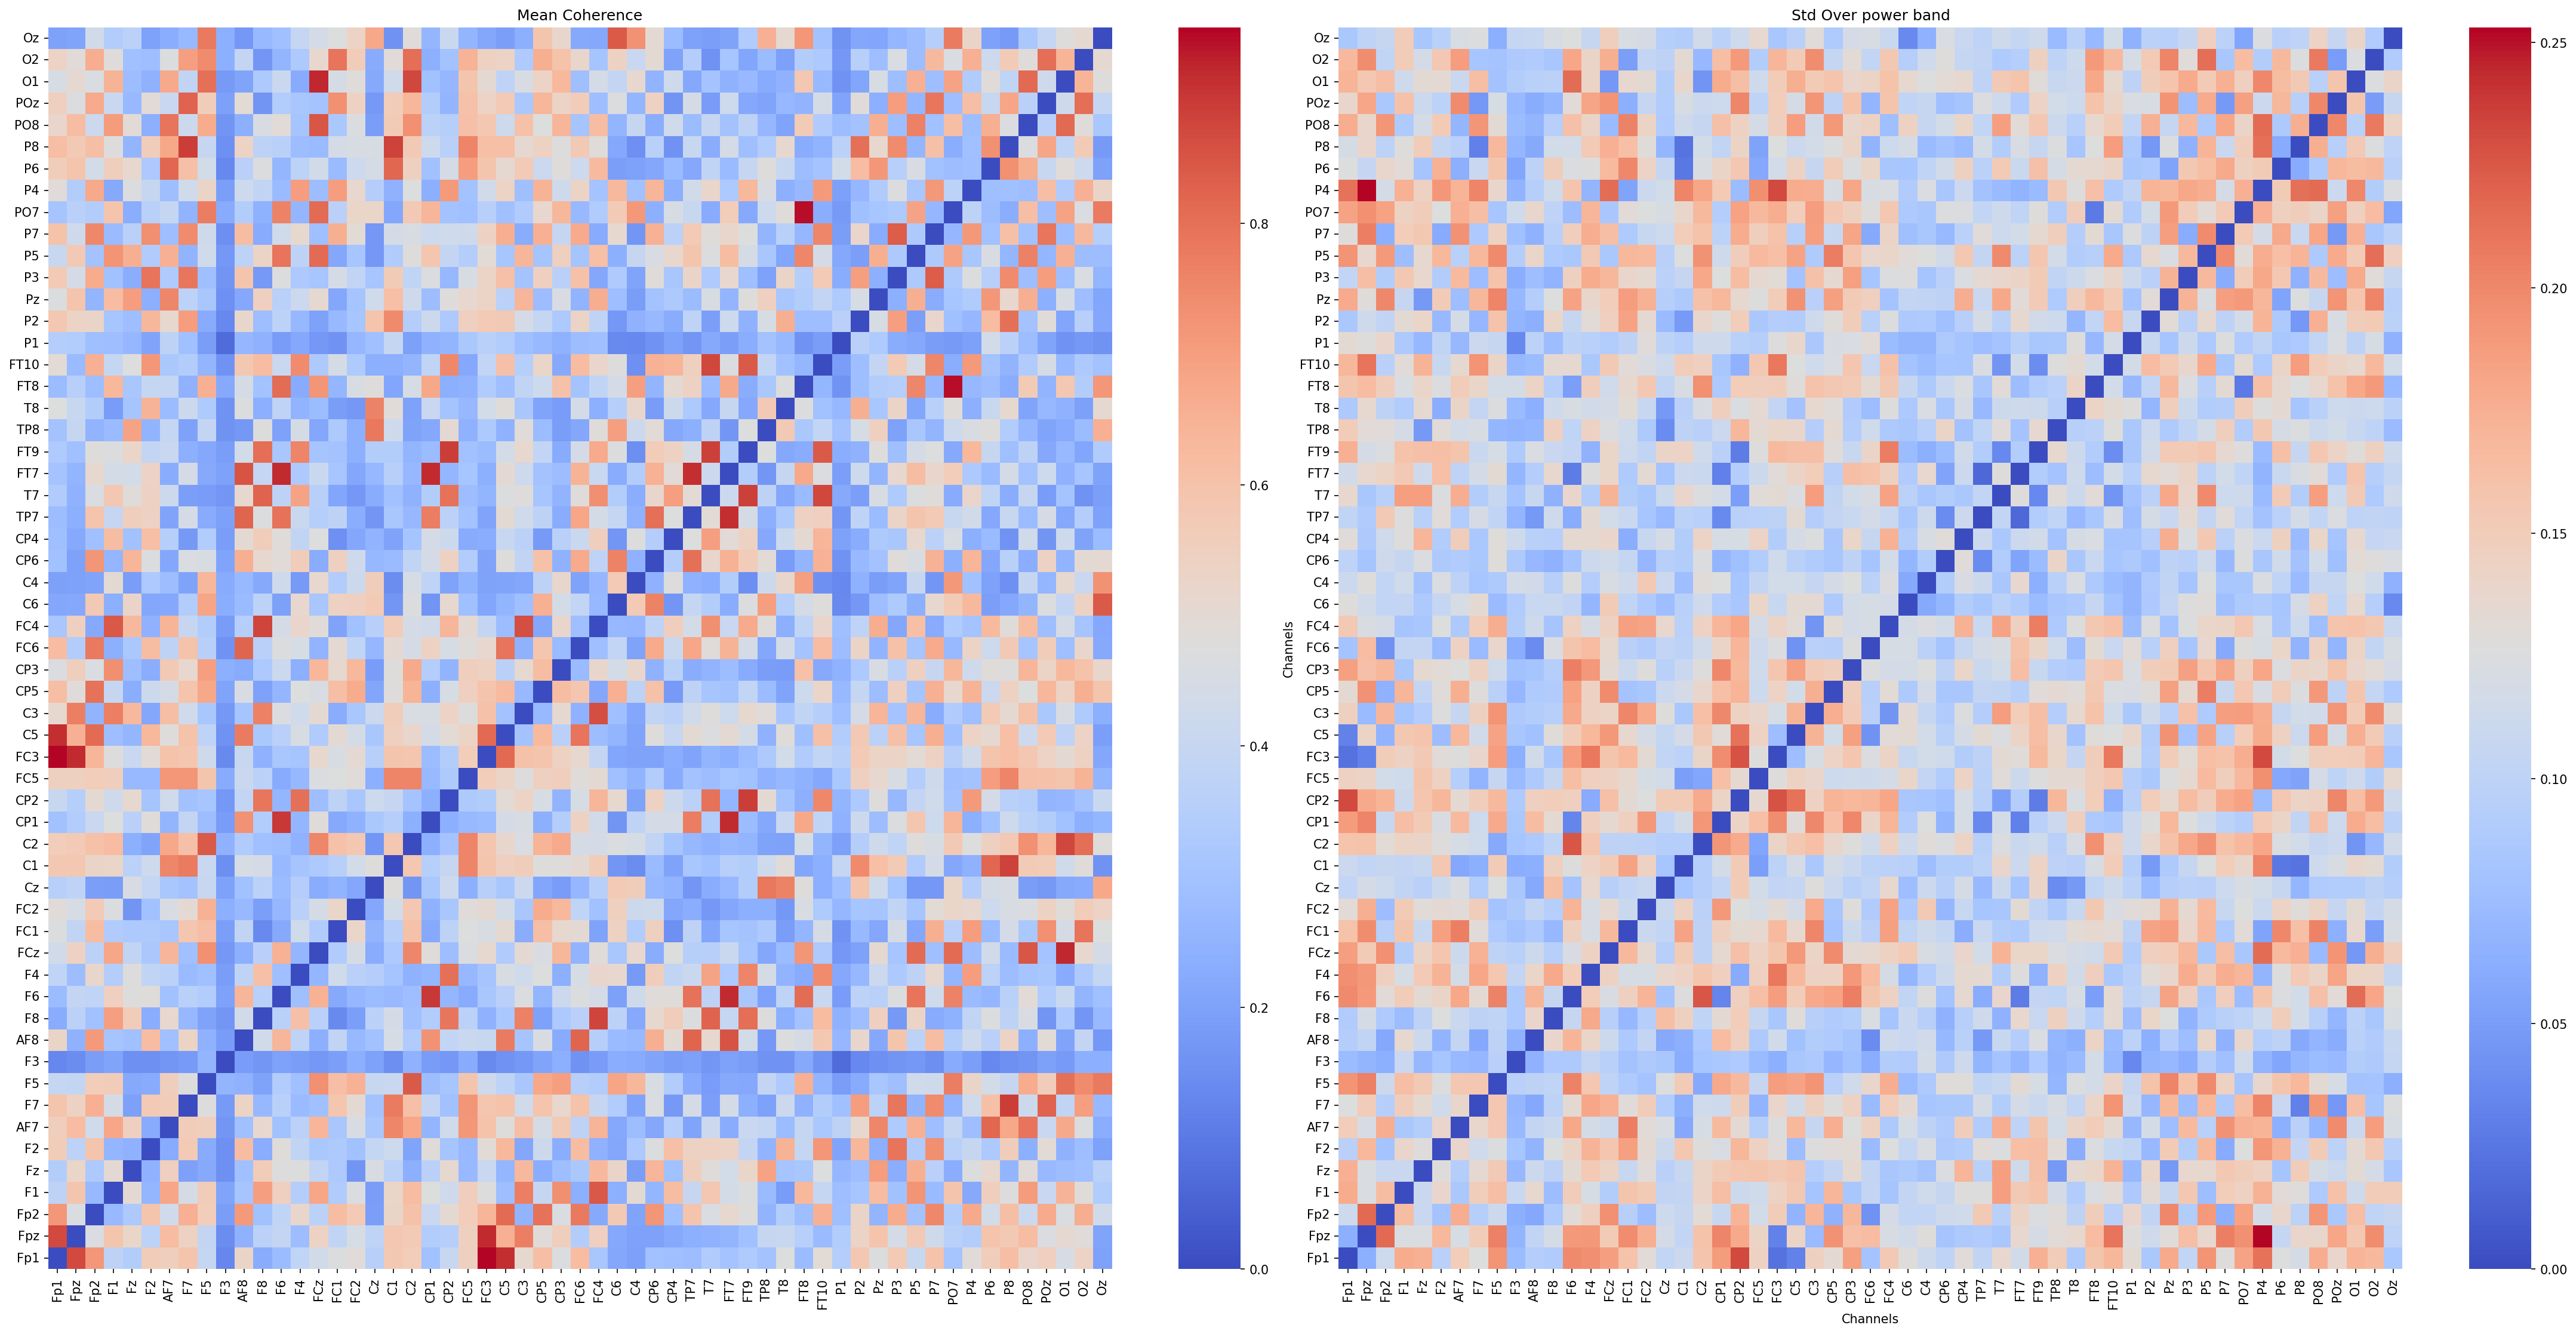

In [95]:
fig = plt.figure()
fig = plt.figure(figsize=(30,15),dpi=150)

ax = fig.add_subplot(1,2,1)
# Customize the heatmap
# sns.heatmap(df.iloc[::-1], cmap='coolwarm', annot=False, fmt=".2f", cbar=True)

sns.heatmap(df_1.iloc[::-1], cmap='coolwarm', annot=False, fmt=".2f", cbar=True)
plt.title('Mean Coherence')

plt.tight_layout()

ax = fig.add_subplot(1,2,2)
sns.heatmap(df.iloc[::-1], cmap='coolwarm', annot=False, fmt=".2f", cbar=True)
plt.title('Std Over power band')

# Add labels and title
plt.xlabel("Channels")
plt.ylabel("Channels")

plt.tight_layout()

# Put the data in a dataframe and plot heatmap 

<Figure size 3000x2000 with 0 Axes>

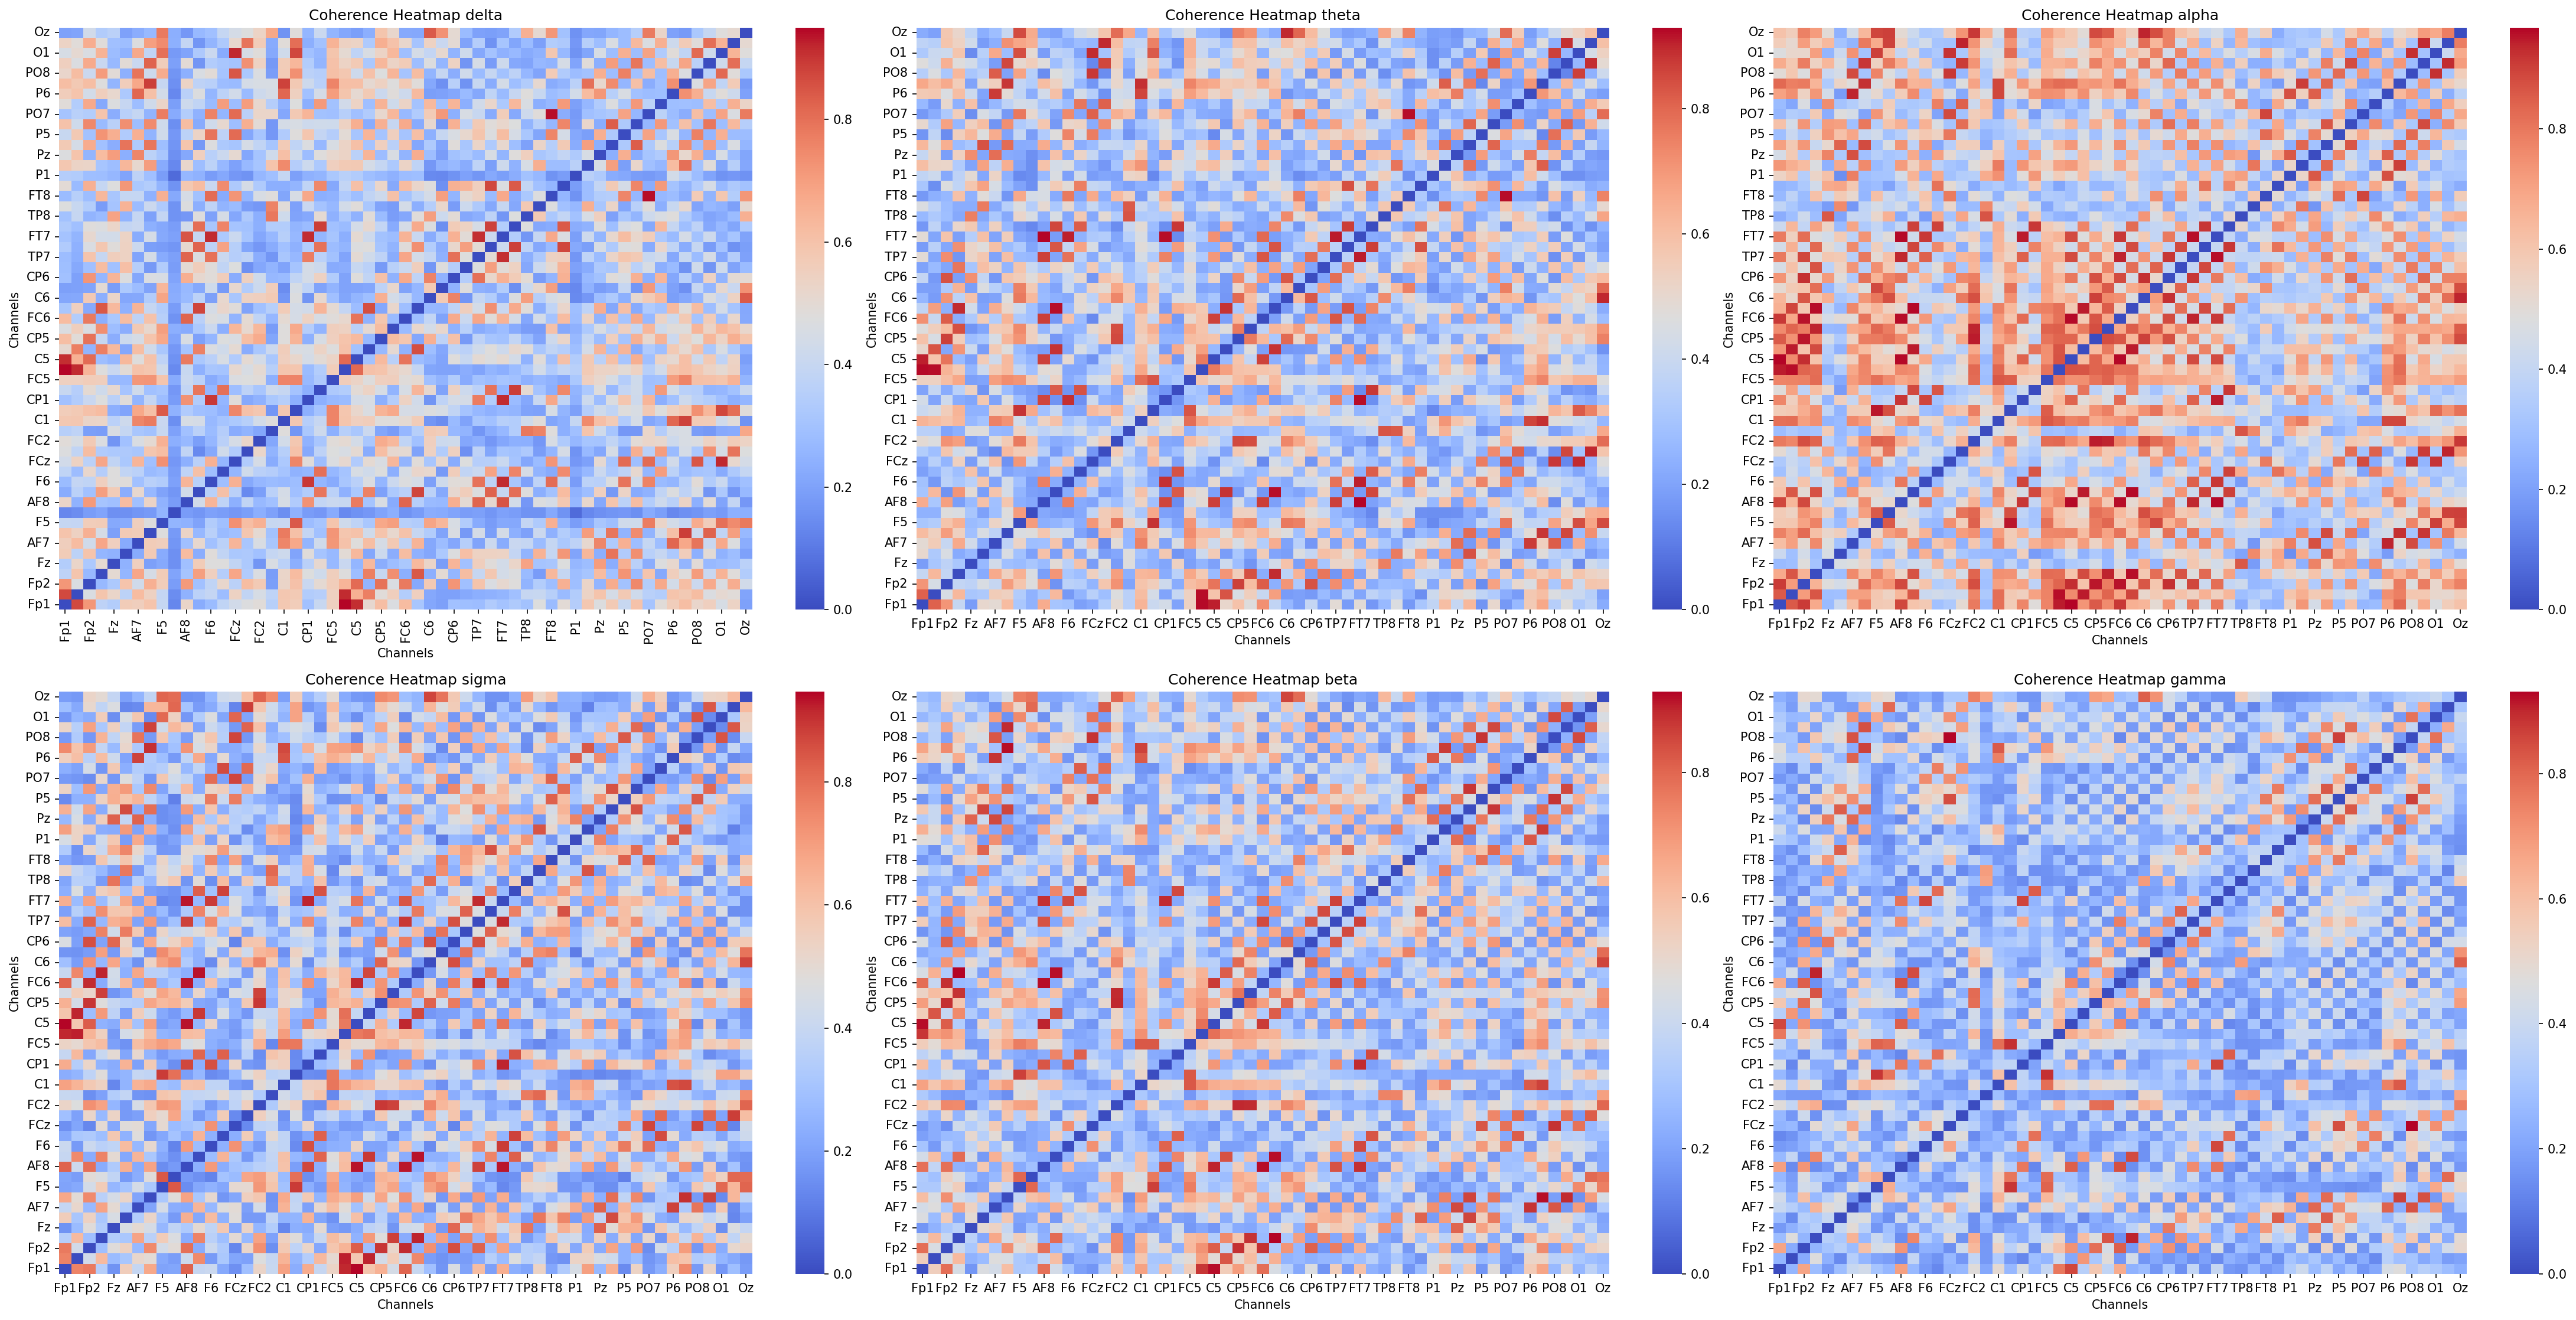

In [132]:
power_bands = {'delta' : (0.5,4) , 'theta' : (4,8) , 'alpha' : (8,12) , 'sigma' : (12,16) , 'beta' : (16,30) , 'gamma' : (30,40) }

fig = plt.figure()
fig = plt.figure(figsize=(30,15),dpi=150)

for power_band_index, power_band in enumerate(list(power_bands.keys())):
    
    channel_names = channels
    connectivity_data = con_pli.get_data('dense')[:, : , power_band_index]
    
    channel_data = connectivity_data
    
    # Create an empty DataFrame
    df = pd.DataFrame(index=channel_names, columns=channel_names)
    
    # Fill the DataFrame with connectivity values
    for i in range(len(channel_names)):
        for j in range(len(channel_names)):
            channel_1 = channel_names[i]
            channel_2 = channel_names[j]
            connectivity_value = channel_data[i, j]
            df.loc[channel_1, channel_2] = connectivity_value
            df.loc[channel_2, channel_1] = connectivity_value
    
    df = df.apply(pd.to_numeric)
    
    # Plot heatmap
    # plt.figure(figsize=(10, 8))  # Set the size of the figure
    ax = fig.add_subplot(2,3,power_band_index+1)
    
    # Customize the heatmap
    sns.heatmap(df.iloc[::-1], cmap='coolwarm', annot=False, fmt=".2f", cbar=True)
    
    # Add labels and title
    plt.xlabel("Channels")
    plt.ylabel("Channels")
    plt.title("Coherence Heatmap " + power_band)

    plt.tight_layout()

plt.tight_layout()
plt.savefig('Coherence_heatmaps_power_bands_wake_example.png')
# # Display the plot
# plt.show()
